# Practica 1

## Problema 2: Laboratorio de control de tempratura BYU

Este modelo representa el [Laboratorio de control de temperatura de BYU](http://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl). El laboratorio de control de temperatura es una aplicación de control con un Arduino, un LED, dos calentadores y dos sensores de temperatura. La potencia de salida del calentador se ajusta para mantener una de las tempraturas en el valor deseado. La energía térmica del calentador se transfiere por conducción, convección y radiación al sensor de temperatura. El calor también se transfiere del dispositivo al entorno.

```{figure} .\tclab_device.png
:name: tclab
:alt: control de teperantura
:width: 250
:align: center

Dispositivo de control de temperatura
```

### Descrpción del problema de control

Con este sistema el objetivo será controlar la temperatura en uno de los calentadores, que es medida mediante la señal $T1$. Para este propósito de control se utiliza la señal $Q1$. 

La señal $Q2$ no podrá ser utilizada por nuestro sitema de control, ya que es utilizada por otro lazo. 

Se tiene una segunda medición $T2$ que es la temperatura de un segundo calentador, pero que no nos interesa controlar.

A continuación se implementa un modelo de este sistema en Python. Para esto primero importamos las herramientas de Python que utilizaremos.

In [1]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np

Escribimos ahora las ecuaciones que gobiernan la dinámica del sistema

In [2]:
def derivs_tclab(t, x, u, params):
    "Las ecuaciones de las derivadads en las ecuaciones de estados"
    Q1 = u[0]
    Q2 = u[1]
    Ta=params.get('Ta', 19)
    P1max=params.get('P1max', 100)
    P2max=params.get('P2max', 200)
    H1 = x[0]
    H2 = x[1]
    T1 = x[2]
    T2 = x[3]
    DeltaTaH1 = Ta - H1
    DeltaTaH2 = Ta - H2
    DeltaT12 = H1 - H2
    dH1 = P1max * Q1 / 5720 + DeltaTaH1 / 20 - DeltaT12 / 100
    dH2 = P2max * Q2 / 5720 + DeltaTaH2 / 20 + DeltaT12 / 100
    dT1 =(H1 - T1)/140
    dT2 = (H2 - T2)/140
    return [dH1, dH2, dT1, dT2]


def output_tclab(t, x, u, params):
    "Las ecuaciones de las salida"
    return [x[2], x[3]]

Con estas ecuaciones implementamos en Python el modelo no lienal del sistema.

In [3]:
tclab_sys = ctrl.NonlinearIOSystem(updfcn=derivs_tclab, 
                                  outfcn=output_tclab, 
                                  inputs=('Q1', 'Q2'), 
                                  outputs=('T1', 'T2'), 
                                  states=['H1', 'H2', 'T1', 'T2'], 
                                  name='susp')

Ahora vamos a definir el vector de entradas $U$, contiene las entradas $T1$ y $T2$ para cada instante definido en un vector $T$.

In [4]:
T=np.linspace(0,2000, 2000)
def Usignal(T):
    U = np.zeros((2, len(T)))
    for i, t in enumerate(T):
        U[0,i] = 50 if t > 400 and t < 1600 else  0
        U[1,i] = 50 if t > 1200 else  0
        
    return U

U=Usignal(T)

Grafico las señales $Q1$ y $Q2$

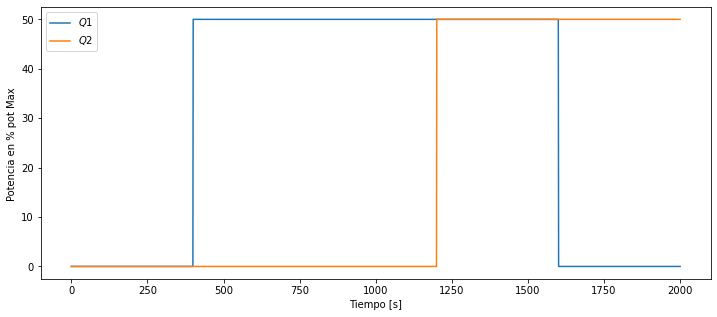

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(T, U[0,:], label=r'$Q1$')
ax.plot(T, U[1,:], label=r'$Q2$')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Potencia en % pot Max ')
ax.legend();

Ahora simularemos la respuesta al sistema a esas dos entradas. Consideraremos que todas las temperaturas del sistema están en equilibrio con la temperatura ambiente (19 grados)

In [30]:
X0 = [19,19, 19, 19]
t,y = ctrl.input_output_response(tclab_sys, T, U, X0)


En $y$ y en $t$ ahora están los valores que toman la salida $y(t) = [T1(t), T2(t)]$, para distintos valores de $t$.

## Práctico 1

1. Hacer un diagrama del bloque del laboratorio de temperatura donde se vean cuales son las entradas y las salidas. De las entradas diferenciar cuales son perturbaciones y cuales son variables manipuladas.

```{figure} .\Punto 2.drawio.png
:name: Diagramadebloques
:alt: Diagrama de Bloques
:width: 1000
:align: center

Diagrama de Bloques
```
1. Viendo la grafica de las entradas anterior, analizar:

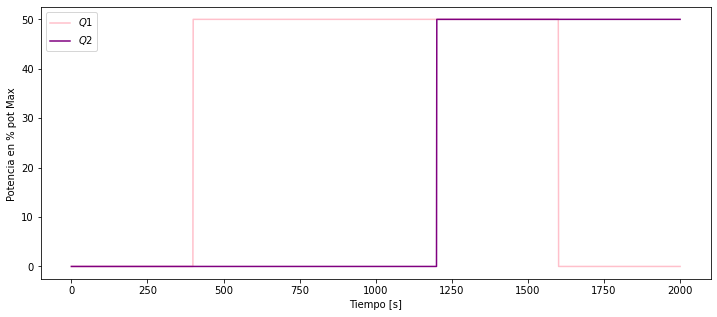

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(T, U[0,:], label=r'$Q1$', color='pink')
ax.plot(T, U[1,:], label=r'$Q2$', color='purple')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Potencia en % pot Max ')
ax.legend();

    - Cuándo entran la perturabación y de que dimensión: 
    
    La perturbación entra en el tiempo t=1200 seg y es de dimensión de 50% de la Potencia Máxima
    
    - cuando entra la señal de control y de que dimensión es y como afecta: 
    
    La señal de control ingresa en el tiempo t=400, es de la misma dimensión que la perturbación 50% de la Potencia máxima y afecta la temperatura del calentador.
    
1. Graficar la salida $y$ obtenida de la simulación del sistema. Analizar la respuesta.

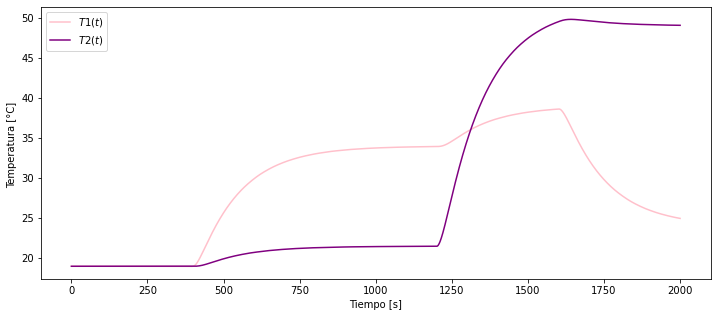

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(T, y[0,:], label=r'$T1(t)$', color='pink')
ax.plot(T, y[1,:], label=r'$T2(t)$', color='purple')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Temperatura [°C] ')
ax.legend();

    - Analizar como varian las salidas consierando las gráficas de $T1$ y $T2$:
    
   $T1$ Aumenta inicialmente frente a la entrada y luego un poco mas por la perturbacion, luego su valor decrece.
    
   $T2$ Crece levemente frente a la entrada $Q1$ y luego lo hace abruptamente frente a la entrada $Q2$
    
    - es correcto usar $Q1$ para controlar $T1$ o es mejor usar $Q2$ para tal fin
    
  Parece ser mejor $Q2$ para controlar $T1$, sin embargo, aumenta fuertemente la temperatura del segundo calentador, lo cual si bien no se espera controlar esta variable, puede ser un efecto no deseado. Al ver que tanto $Q1$ como $Q2$ influyen en el valor de $T1$ se determina que la que produce una mayor variacion en la medida es la ideal, lo cual corresponde al caso de $Q2$.
    
    

Ayuda: 
- Utilizar como referencia el código de las gráficas de $U$ para hacer la gráfica de $y$
- con `y.shape` y `t.shape` obtenemos la "forma" de la señal. Por ejemplo, la señal $U$ de la figura anterior tiene `(2, 2000)`, es decir, 2 filas (una para $u$ y otra para $w$) y 2000 columnas (una para cada instante simulado).
- para hacer el diagrama de bloques usar como referencia el apunte de introducción a señales y sistemas.